In [5]:
from train import load_data

train_loader, test_loader, val_loader = load_data(batch_size=1, split='tier1')

Loading test_df from file
Loading train_df from file
Loading hold_df from file
Train data loading complete
Test data loading complete


In [33]:
import torch

mean = torch.zeros(6)
std = torch.zeros(6)
total_pixels = 0

# First pass: Calculate mean
for images, _, _ in train_loader:
    # Flatten the images to (B, C, H*W) to sum across height and width
    images = images[0].unsqueeze(0)
    # print(images.shape)
    images = images.view(images.size(0), images.size(1), -1)
    mean += images.mean(dim=(0, 2)) * images.size(0)
    total_pixels += images.size(0)

mean /= total_pixels

# Second pass: Calculate std
for images, _, _ in train_loader:
    images = images[0].unsqueeze(0)
    images = images.view(images.size(0), images.size(1), -1)
    std += ((images - mean.view(1, -1, 1)) ** 2).sum(dim=(0, 2))

std = torch.sqrt(std / (total_pixels * images.size(2)))

print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: tensor([0.3052, 0.3381, 0.2510, 0.3073, 0.3427, 0.2542])
Std: tensor([0.1630, 0.1449, 0.1360, 0.1609, 0.1426, 0.1348])


In [34]:
import torch

mean = torch.zeros(6)
std = torch.zeros(6)
total_pixels = 0

# First pass: Calculate mean
for images, _ in test_loader:
    # Flatten the images to (B, C, H*W) to sum across height and width
    images = images[0].unsqueeze(0)
    # print(images.shape)
    images = images.view(images.size(0), images.size(1), -1)
    mean += images.mean(dim=(0, 2)) * images.size(0)
    total_pixels += images.size(0)

mean /= total_pixels

# Second pass: Calculate std
for images, _ in test_loader:
    images = images[0].unsqueeze(0)
    images = images.view(images.size(0), images.size(1), -1)
    std += ((images - mean.view(1, -1, 1)) ** 2).sum(dim=(0, 2))

std = torch.sqrt(std / (total_pixels * images.size(2)))

print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: tensor([0.1395, 0.1422, 0.1433, 0.1370, 0.1298, 0.1318])
Std: tensor([0.2325, 0.2271, 0.2217, 0.2182, 0.2048, 0.2003])


In [35]:
import torch

mean = torch.zeros(6)
std = torch.zeros(6)
total_pixels = 0

# First pass: Calculate mean
for images, _, _ in val_loader:
    # Flatten the images to (B, C, H*W) to sum across height and width
    images = images[0].unsqueeze(0)
    # print(images.shape)
    images = images.view(images.size(0), images.size(1), -1)
    mean += images.mean(dim=(0, 2)) * images.size(0)
    total_pixels += images.size(0)

mean /= total_pixels

# Second pass: Calculate std
for images, _, _ in val_loader:
    images = images[0].unsqueeze(0)
    images = images.view(images.size(0), images.size(1), -1)
    std += ((images - mean.view(1, -1, 1)) ** 2).sum(dim=(0, 2))

std = torch.sqrt(std / (total_pixels * images.size(2)))

print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: tensor([0.3049, 0.3365, 0.2522, 0.3075, 0.3412, 0.2556])
Std: tensor([0.1617, 0.1447, 0.1357, 0.1604, 0.1420, 0.1342])


: 

In [6]:
import torch
from torchvision import models, transforms
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np

resnet = models.resnet50(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1]) 
resnet.eval() 
resnet = resnet.cuda() 

preprocess = transforms.Compose([
                transforms.Resize((224, 224)), 
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])

/home/deependra/.conda/envs/nlrc/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/deependra/.conda/envs/nlrc/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
from tqdm import tqdm
import os

def extract_features(loader, model, batch_size=32, collate=None):

    features = []
    with torch.no_grad():
        for imgs, targets, counts in tqdm(loader):
            # print(f"image shape: {imgs[0].shape}")
            img_post = imgs[0][:3, :, :]
            img_pre = imgs[0][3:, :, :]
            # print(f"image shape post: {img_post.shape}")
            # print(f"image shape pre: {img_pre.shape}")
            # imgs = torch.stack(imgs[0]).cuda()
            
            # preprocess the image
            img_post = Image.fromarray(img_post.permute(1, 2, 0).numpy().astype(np.uint8))
            img_post = preprocess(img_post).unsqueeze(0).cuda()
            
            img_pre = Image.fromarray(img_pre.permute(1, 2, 0).numpy().astype(np.uint8))
            img_pre = preprocess(img_pre).unsqueeze(0).cuda()
            
            feats = model(img_post)
            feats_pre = model(img_pre)
            # print(f"feats shape: {feats.shape}")
            features.append(feats.cpu().numpy())
    return np.vstack(features)

if not os.path.exists("/home/deependra/Dataset/resnet_features/train_features.npy"):
    train_features = extract_features(train_loader, resnet)
    np.save("/home/deependra/Dataset/resnet_features/train_features.npy", train_features)
    print("Features saved as train_features.npy")
else:
    train_features = np.load("/home/deependra/Dataset/resnet_features/train_features.npy")

In [25]:
if not os.path.exists("/home/deependra/Dataset/resnet_features/val_features.npy"):
    val_features = extract_features(val_loader, resnet)
    np.save("/home/deependra/Dataset/resnet_features/val_features.npy", val_features)
    print("Features saved as val_features.npy")
else:
    val_features = np.load("/home/deependra/Dataset/resnet_features/val_features.npy")

100%|██████████| 933/933 [13:07<00:00,  1.18it/s]

Features saved as train_features.npy


In [18]:
def extract_features(loader, model, batch_size=32, collate=None):

    features = []
    with torch.no_grad():
        for imgs, img_id in tqdm(loader):
            # print(f"image shape: {imgs[0].shape}")
            img_post = imgs[0][:3, :, :]
            img_pre = imgs[0][3:, :, :]
            # print(f"image shape post: {img_post.shape}")
            # print(f"image shape pre: {img_pre.shape}")
            # imgs = torch.stack(imgs[0]).cuda()
            
            # preprocess the image
            img_post = Image.fromarray(img_post.permute(1, 2, 0).numpy().astype(np.uint8))
            img_post = preprocess(img_post).unsqueeze(0).cuda()
            
            img_pre = Image.fromarray(img_pre.permute(1, 2, 0).numpy().astype(np.uint8))
            img_pre = preprocess(img_pre).unsqueeze(0).cuda()
            
            feats = model(img_post)
            feats_pre = model(img_pre)
            # print(f"feats shape: {feats.shape}")
            features.append(feats.cpu().numpy())
    return np.vstack(features)

test_features = extract_features(test_loader, resnet)

100%|██████████| 348/348 [00:37<00:00,  9.32it/s]


In [19]:
np.save("/home/deependra/Dataset/resnet_features/test_features_original.npy", test_features)
print("Features saved as test_features_original.npy")

Features saved as test_features_original.npy


In [20]:
train_features_new = train_features.squeeze(-1).squeeze(-1)

In [27]:
val_features_new = val_features.squeeze(-1).squeeze(-1)

In [21]:
test_features_new = test_features.squeeze(-1).squeeze(-1)

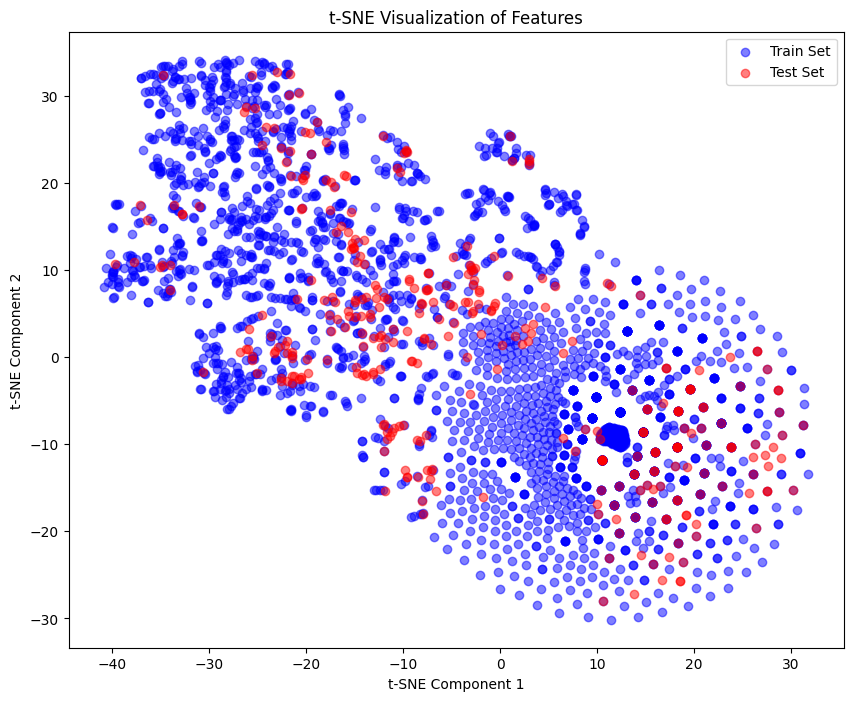

In [22]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np


features = np.concatenate([train_features_new, test_features_new])
labels = np.concatenate([np.zeros(len(train_features_new)), np.ones(len(test_features_new))]) 

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
reduced_features_tsne = tsne.fit_transform(features)

plt.figure(figsize=(10, 8))
plt.scatter(
    reduced_features_tsne[labels == 0, 0], 
    reduced_features_tsne[labels == 0, 1], 
    c='blue', label='Train Set', alpha=0.5
)
plt.scatter(
    reduced_features_tsne[labels == 1, 0], 
    reduced_features_tsne[labels == 1, 1], 
    c='red', label='Test Set', alpha=0.5
)
plt.title('t-SNE Visualization of Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()


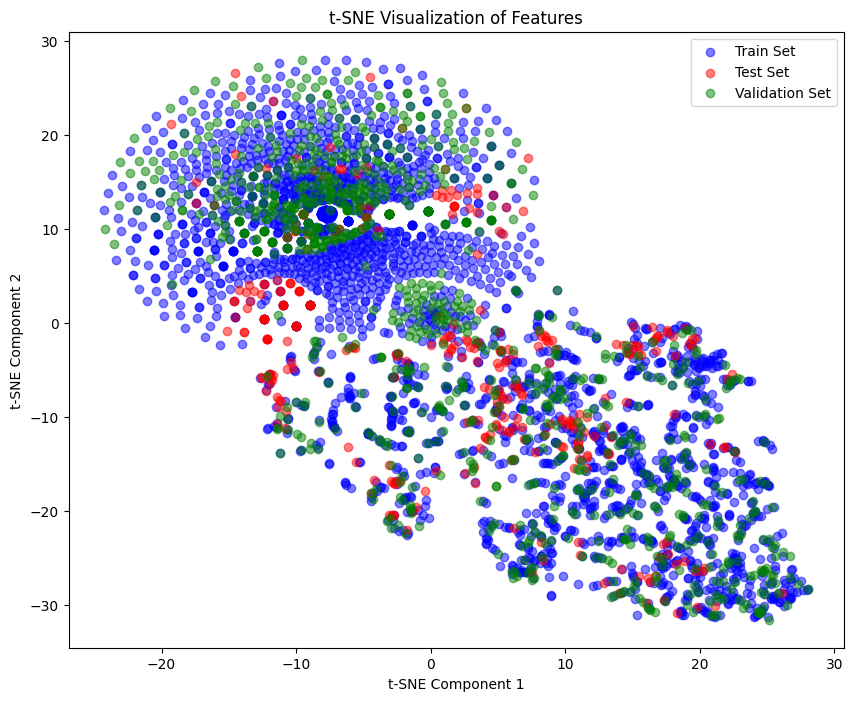

In [28]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Concatenate all features and create labels for train, test, and validation
features = np.concatenate([train_features_new, test_features_new, val_features_new])
labels = np.concatenate([
    np.zeros(len(train_features_new)),  # Train: label 0
    np.ones(len(test_features_new)),   # Test: label 1
    np.full(len(val_features_new), 2)  # Validation: label 2
])

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
reduced_features_tsne = tsne.fit_transform(features)

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))

# Train set
plt.scatter(
    reduced_features_tsne[labels == 0, 0], 
    reduced_features_tsne[labels == 0, 1], 
    c='blue', label='Train Set', alpha=0.5
)

# Test set
plt.scatter(
    reduced_features_tsne[labels == 1, 0], 
    reduced_features_tsne[labels == 1, 1], 
    c='red', label='Test Set', alpha=0.5
)

# Validation set
plt.scatter(
    reduced_features_tsne[labels == 2, 0], 
    reduced_features_tsne[labels == 2, 1], 
    c='green', label='Validation Set', alpha=0.5
)

# Add titles and labels
plt.title('t-SNE Visualization of Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()
